# Get Precursor results
This notebook presents Precursor data in Full Network and Target Mode.


To run correctly this notebook and have the same results as the paper, you must first download the raw results: [https://doi.org/10.57745/OS1JND](https://doi.org/10.57745/OS1JND)

This notebook is written with the hierarchy of downloaded files, if you want to try it with the test form the run notebooks, it is needed to first restructure your data to match the hierarchy of downloaded files.

We suppose here that the downloaded files are in a directory named "analyses", this directory path can be changed to your directory path where the data are saved.

## Requirements
Module *numpy*, *seaborn* and *scipy* are needed

In [ ]:
!pip install numpy

In [ ]:
!pip install seaborn

In [ ]:
!pip install scipy

# Variable to change (if wanted)

In [1]:
analyse_dir = "../../analyses"

# Initialisation and functions

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import numpy as np

In [3]:
precursor_results_dir = os.path.join(analyse_dir, "results", "precursor_formated_results")
s2lp_supp_data = os.path.join(analyse_dir, "results", "supp_data", "seed2lp_supp_data.tsv")

In [4]:
def get_fluxes(directory:str, mode:str):
    flux_all=pd.DataFrame(columns=['species', 'biomass_reaction', 'solver_type', 'search_mode',
                                     'search_type', 'accumulation', 'model', 'size', 'lp_flux', 'cobra_flux_init',
                                     'cobra_flux_no_import', 'cobra_flux_seeds', 'cobra_flux_demands',
                                     'has_flux', 'has_flux_seeds', 'has_flux_demands', 'timer'])
    flux_all['accumulation'] = flux_all['accumulation'].astype('bool')
    flux_all['has_flux'] = flux_all['has_flux'].astype('bool')
    flux_all['has_flux_seeds'] = flux_all['has_flux_seeds'].astype('bool')
    flux_all['has_flux_demands'] = flux_all['has_flux_demands'].astype('bool')

    for dirpath, _, filenames in os.walk(directory):
        for filename in [f for f in filenames if (f.endswith("_fluxes.tsv") or f.endswith("_fluxes_from_result.tsv"))]:
            # By default in this notebook we want the no accumulation mode for seed2lp results
            if  (mode == "full" and "_fn_" in filename) \
                or (mode == "target" and "_tgt_" in filename):
                file_path=os.path.join(dirpath, filename)
                current_df = pd.read_csv(file_path, sep='\t', lineterminator='\n')
                current_df['accumulation'] = current_df['accumulation'].astype('bool')
                current_df['has_flux'] = current_df['has_flux'].astype('bool')
                current_df['has_flux_seeds'] = current_df['has_flux_seeds'].astype('bool')
                current_df['has_flux_demands'] = current_df['has_flux_demands'].astype('bool')
                flux_all=pd.concat([flux_all if not flux_all.empty else None, current_df], ignore_index=True)
    return flux_all

In [5]:
def get_sizes(flux_df:pd.DataFrame, nb_total_meta:pd.DataFrame):
    list_mean_size = flux_df.groupby(['species'])['size'].mean()
    mean_size_df = pd.DataFrame(list_mean_size)
    data_size_df = pd.concat([nb_total_meta, mean_size_df], axis=1)
    data_size_df["percent"]=data_size_df["size"] / data_size_df["number_metabolites"] *100
    data_size = pd.DataFrame(data_size_df["percent"])
    data_size=data_size.reset_index()
    data_size=data_size.rename(columns={"index": "species"})
    return data_size

In [6]:
def get_total_nb_meta(supp_data_file):
    table_all = pd.read_csv(supp_data_file, sep='\t', lineterminator='\n')
    union_all = table_all.loc[table_all["type_data"] == "Union"]
    num_metabolite = union_all.groupby(['network'])['number_metabolites'].first()
    return pd.DataFrame(num_metabolite)

In [7]:
def create_table_plot(table,column_name):
    new_table = table.groupby(['species'])[column_name].agg('count').reset_index()
    new_table=new_table.rename(columns={column_name: "Total_flux"})
    new_true = table[table[column_name]==True].groupby(['species'])[column_name].agg('count').reset_index()
    new_true=new_true.rename(columns={column_name: "True_flux"})
    new_false = table[table[column_name]==False].groupby(['species'])[column_name].agg('count').reset_index()
    new_false=new_false.rename(columns={column_name: "False_flux"})
    new_table=pd.merge(new_table,new_true, how='left', on=['species'])
    new_table=pd.merge(new_table,new_false, how='left', on=['species'])
    new_table=new_table.fillna(0)
    new_table=new_table.fillna(0)
    new_table['True_flux']=new_table['True_flux'].astype(int)
    new_table['False_flux']=new_table['False_flux'].astype(int)
    return new_table

In [8]:
def get_all_same_validation_fba(table,type):
    count=0
    total=0
    for _,line in table.iterrows():
        if line[type] == line["Total_flux"]:
            count += 1
            total += 1
        else:
            total += 1
    
    return total, count

In [9]:
def create_one_plot(s2lp, netseed, labels):
    plt.style.use("seaborn-v0_8-colorblind")

    _, s2lp_true_count = get_all_same_validation_fba(s2lp, "True_flux")
    _, s2lp_false_count = get_all_same_validation_fba(s2lp,"False_flux")
    s2lp_missing_networks = 107 - (s2lp_true_count + s2lp_false_count)

    _, netseed_true_count =  get_all_same_validation_fba(netseed, "True_flux")
    _, netseed_false_count = get_all_same_validation_fba(netseed, "False_flux")
    netseed_missing_networks = 107 - (netseed_true_count + netseed_false_count)


    s2lp_tab=pd.DataFrame([[s2lp_true_count, s2lp_false_count, s2lp_missing_networks]], 
                          columns=["all_true","all_false","missing"])
    s2lp_tab=s2lp_tab.assign(Tool=labels[0])

    netseed_tab=pd.DataFrame([[netseed_true_count, netseed_false_count, netseed_missing_networks]],
                              columns=["all_true","all_false","missing"])
    netseed_tab=netseed_tab.assign(Tool=labels[1])

    concat_table = pd.concat([netseed_tab,s2lp_tab])


    plt.figure(figsize=(1,3))
    sns.set_theme(font_scale = 1.5)
    fig, ax = plt.subplots()
    fig.tight_layout()
    groups = concat_table['Tool']
    ax.bar(groups, concat_table["all_true"], color='#1e73be',label='flux', width=0.2)
    ax.bar(groups, concat_table["all_false"], bottom = concat_table["all_true"], 
           color='#ef3340', label='no flux', width=0.2)
    ax.bar(groups, concat_table["missing"], bottom = concat_table["all_true"]+concat_table["all_false"], 
           color='black', label='no solution', width=0.2)
    
    plt.ylabel('Number of GSMNs', fontsize=25)
    plt.xlabel('Tools', fontsize=25)
    plt.xticks(size=22)
    plt.yticks(size=22)
    #sns.despine(bottom=True)
    plt.tick_params(bottom=False, left=True)
    plt.legend(frameon=True,  loc='center right', borderaxespad=-10)
    return 

In [10]:
def get_mean_std_deviation(table, tool):
    mean = table["Total_flux"].mean()
    std = table["Total_flux"].std()
    print(tool, f"mean = {mean}",  f"standard deviation = {std}")

In [22]:
def plot_compare(s2lp:pd.DataFrame, netseed:pd.DataFrame, col, labels, do_kruskal:bool=True, 
                 is_precursor:bool=False, y_label:str=""):
    np.set_printoptions(precision=3)
    plt.style.use("seaborn-v0_8-colorblind")


    nan_spec=s2lp[s2lp[col].isnull()]["species"]
    for nspe in nan_spec:
        s2lp=s2lp.drop(s2lp.loc[s2lp['species']==nspe].index)

    nan_spec=netseed[netseed[col].isnull()]["species"]
    for nspe in nan_spec:
        netseed=netseed.drop(netseed.loc[netseed['species']==nspe].index)

    del_spec=set(netseed['species']) - set(s2lp['species'])
    for sp in del_spec:
        netseed=netseed.drop(netseed.loc[netseed['species']==sp].index)

    n = len(s2lp['species'].unique())
    
    s2lp=s2lp.assign(Tool=labels[0])
    netseed=netseed.assign(Tool=labels[1])
    
    concat_table = pd.concat([s2lp, netseed])

    scope_tab = concat_table.groupby(['species','Tool'])[col].mean()
    scope_df=pd.DataFrame(scope_tab)
    scope_df=scope_df.reset_index()
    plt.figure(figsize=(3,4))
    sns.set_theme(font_scale = 1.5)

    prec_fn_means= scope_df[scope_df['Tool']==labels[0]]
    prec_t_means= scope_df[scope_df['Tool']==labels[1]]
    prec_fn_mean=prec_fn_means[col].mean()
    pref_t_means=prec_t_means[col].mean()
    print(f"{labels[0]} global mean: ",prec_fn_mean, f"\t {labels[1]} global mean: ", pref_t_means)

    # KRUSKAL WALLIS TESTS
    # Get the p-value from Kruskall Wallis test
    if do_kruskal:
        kstat, p_value = kruskal(scope_df[scope_df["Tool"]==labels[1]][col], scope_df[scope_df["Tool"]==labels[0]][col])

    sns.boxplot(data=scope_df, x="Tool", y=col, hue="Tool", fill=False, linewidth=1.5)
    plt.xlabel('')
    plt.ylabel(y_label)
    plt.title(f"kstat = {kstat}, p-value = {p_value}, n={n}")
    sns.despine(bottom=True)
        

In [28]:
def get_min_max(tab, mode):
    print(f'Set of seed size for {mode}\n min: {tab["size"].min()}\tmax: {tab["size"].max()}')

In [37]:
def get_nb_and_percent_sol(tab, limit):
    nb = len(tab[tab["Total_flux"]<=limit])
    print(f"Number of GSMNs having less than {limit} solutions: {nb} networks ({nb/1.07} %)")

In [51]:
def get_iCN718_sol(tab:pd.DataFrame, mode):
    tab=tab[tab["species"]=="iCN718"]
    nb = len(tab)
    val_count = tab["size"].value_counts()
    print(f"Total number of solutions for iCN718 in {mode}: {nb}")
    for row in val_count.items():
        print(f"size: {row[0]}\t count: {row[1]}")

# Get data

In [12]:
flux_precursor_FN_submin = get_fluxes(precursor_results_dir, "full")
flux_precursor_T_submin = get_fluxes(precursor_results_dir, "target")

In [13]:
nb_total_meta_df = get_total_nb_meta(s2lp_supp_data)

In [14]:
data_size_FN = get_sizes(flux_precursor_FN_submin, nb_total_meta_df)
data_size_T = get_sizes(flux_precursor_T_submin, nb_total_meta_df)

In [15]:
FN_flux=create_table_plot(flux_precursor_FN_submin,'has_flux')
T_flux=create_table_plot(flux_precursor_T_submin,'has_flux')

# PLOT

## Fluxes analyses

### Mean and standard deviation

In [16]:
get_mean_std_deviation(FN_flux, "Full Network")

Full Network mean = 664.0560747663551 standard deviation = 465.29006639145047


In [17]:
get_mean_std_deviation(T_flux, "Target")

Target mean = 56.205607476635514 standard deviation = 142.52373111353674


### Plot number of fluxes validating (all solutions validates) or not (none of solution validates) FBA

<Figure size 100x300 with 0 Axes>

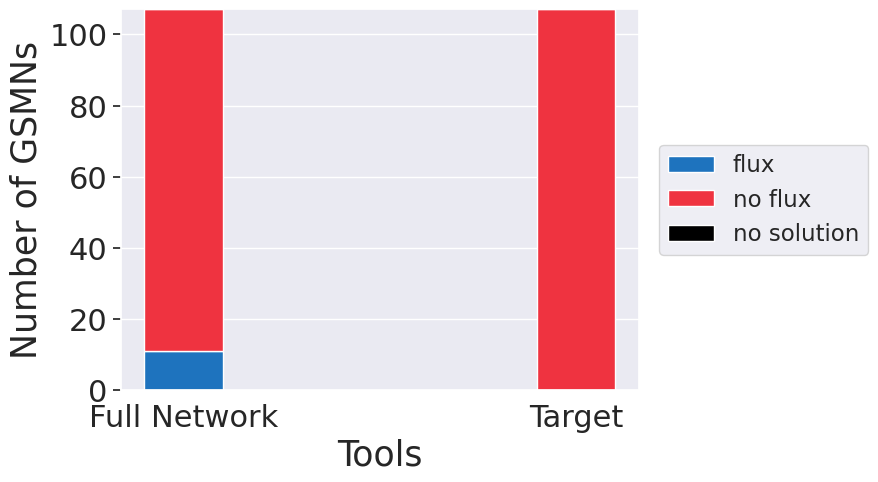

In [18]:
create_one_plot(T_flux, FN_flux, ["Target","Full Network"])

## Set of seeds solution analyses

> Notes:
>
> On the above plot, "global mean" is a mean of means per network (all solutions, up to 1000, are averaged by network, then an average of those is performed)

In [29]:
get_min_max(flux_precursor_FN_submin, "Full Network")

Set of seed size for Full Network
 min: 6	max: 285


In [30]:
get_min_max(flux_precursor_T_submin, "Target")

Set of seed size for Target
 min: 1	max: 18


In [38]:
get_nb_and_percent_sol(T_flux,8)

Number of GSMNs having less than 8 solutions: 88 networks (82.2429906542056 %)


Full Network global mean:  11.356633293864068 	 Target global mean:  0.228610193536069


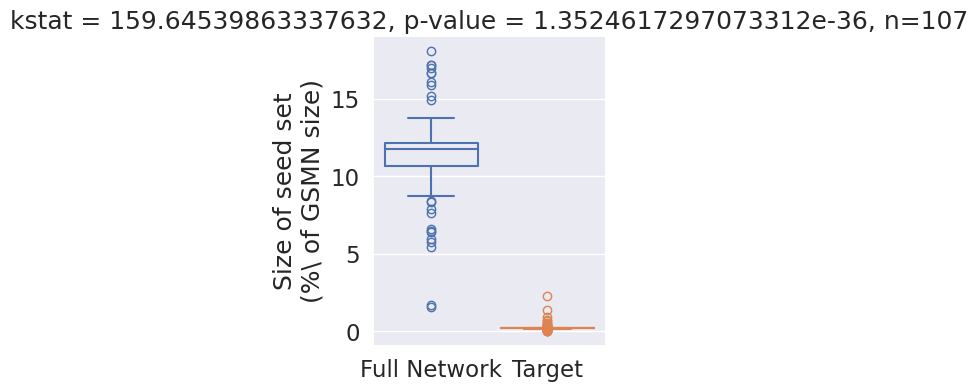

In [23]:
plot_compare(data_size_FN, data_size_T, 'percent',  ["Full Network", "Target"], 
             y_label="Size of seed set\n(%\ of GSMN size)")

## iCN718 analyses

In [52]:
get_iCN718_sol(flux_precursor_FN_submin, "Full Network")

Total number of solutions for iCN718 in Full Network: 1
size: 141	 count: 1


In [53]:
get_iCN718_sol(flux_precursor_T_submin, "Target")

Total number of solutions for iCN718 in Target: 246
size: 1	 count: 245
size: 2	 count: 1
